57 вариант

E U N W K T M L R I

In [506]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import math
import scipy
from collections import Counter
%matplotlib inline

 - 1

In [373]:
from BranchingProcess import Person, BranchingProcess, read_from_files
file_pref = ['E','U','N','W','K','T','M','L','R','I']
file_all = 'C,D,E,F,G,I,J,K,L,M,N,O,P,Q,R,S,T,U,W'
pref_all = file_all.split(',')
file_names = ['data/' + pref + '.txt' for pref in pref_all]

In [374]:
processes = read_from_files(file_names)

In [375]:
print(len(processes))

128097


In [376]:
# delete dummy nodes (with unknown gender and has no children(leaf in generation-tree))
def clear_data(processes) :
    processes_new = []
    for proc in processes :
        new_proc = BranchingProcess()
        children = set()
        proc.generations.reverse()

        for generation in proc.generations:
            new_generation = []
            for person in generation :
                
                if person.gender == 'male' or person.gender == 'female':
                    children.add(person.name)
                    new_generation.append(person)    
                else :     
                    is_leaf = True
                    for ch in person.children:
                        if ch in children :
                            is_leaf = False
                            break
                    if not is_leaf :
                        new_generation.append(person)    

            if len(new_generation) > 0 :
                new_generation.reverse()
                new_proc.generations.append(new_generation)

        if len(new_proc.generations) > 1 :
            processes_new.append(new_proc)
    return processes_new


In [377]:
processes = clear_data(processes)

In [378]:
print(len(processes))

36579


In [379]:
# check that all deleted items were leafs
for proc in processes :
    for generation in proc.generations:
        for person in generation :
            if person.gender != 'male' and person.gender != 'female':
                print("Empty NO-leaf")

- 2

In [380]:
lenghts = [len(proc.generations) for proc in processes]
min_family_length = np.min(lenghts)
max_family_length = np.max(lenghts)
avg_family_length = np.mean(lenghts)
print('min family length = ' + str(min_family_length))
print('max family length = ' + str(max_family_length))
print('avg family length = ' + str(round(avg_family_length,2)))

min family length = 2
max family length = 81
avg family length = 3.31


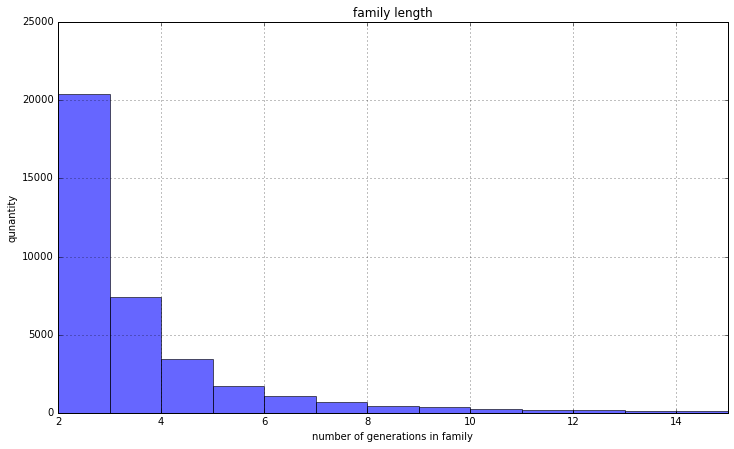

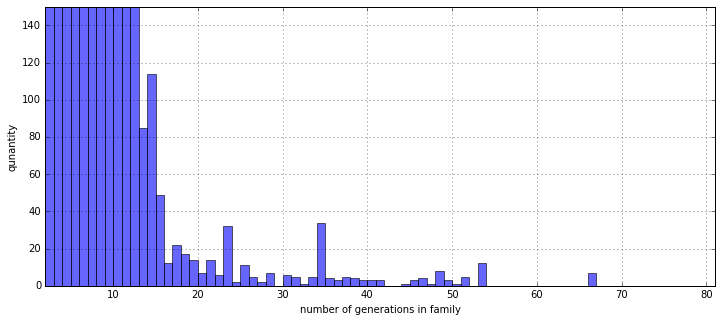

In [381]:
plt.figure(figsize=(12,7))
plt.title("family length")

plt.hist(lenghts, bins=np.arange(80), facecolor='b', alpha=0.6)
plt.grid(True)
plt.xlim(2,15)
plt.xlabel("number of generations in family")
plt.ylabel("qunantity")
plt.show()


plt.figure(figsize=(12,5))
plt.grid(True)
plt.ylim(0,150)
plt.xlim(2,81)
plt.xlabel("number of generations in family")
plt.ylabel("qunantity")
plt.hist(lenghts,  bins=np.arange(80), facecolor='b', alpha=0.6)
plt.show()


In [382]:
# this function returns year(int) from date-info string
def get_year(s) : 
    if len(s) == 0:
        return -5000
    x = s.split('-')
    if(x[0] == '') :
        return -5000
    return int(x[0])


birth_years = []
life_time = []
for proc in processes :
    for generation in proc.generations :
        for p in generation : 
            byear = get_year(p.birthday)
            dyear = get_year(p.deathdate)
            if byear > -5000:
                birth_years.append(byear)
                if dyear > -5000 :
                    life_time.append(dyear - byear)
            
min_birthyear , max_birthyear = np.min(birth_years) , np.max(birth_years)
avg_life_time = np.mean(life_time)
print('min value of birthyear = ' + str(min_birthyear))
print('max value of birthyear = ' + str(max_birthyear))
print('avg value of life time = ' + str(round(avg_life_time,1)))

min value of birthyear = 1
max value of birthyear = 2007
avg value of life time = 57.4


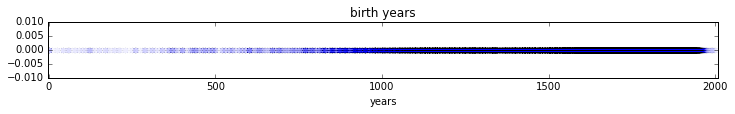

In [383]:
plt.figure(figsize=(12,1))
plt.ylim(-0.01,0.01)
plt.xlim(-1,2008)
plt.xlabel("years")
plt.title("birth years")
plt.plot([x for x in birth_years],[0 for i in range(len(birth_years))],'o',alpha = 0.002)
plt.show()

- 3

In [384]:
def pois_likelyhood_estimation(X) :
    return np.mean(X)    

In [385]:
def normalize_name(s) :
    return s.replace(' ' , '_')


#  add only non-leaf(not last generation in family) and older than 1950 birth year
#  delete if p has no death-year(but he must be already died)
def is_bad_example(person) :
    return get_year(person.birthday) <= -5000 or get_year(person.birthday) >= 1950 
#         or (get_year(person.deathdate) <= -5000 and get_year(person.birthday) <= 1920) 
            

X = []
# print(processes[1].generations[0][0])
t = 0
for proc in processes :
    offspring = dict()
    # calc number of sons for each father
    for generation in proc.generations:
        for person in generation :
            person.name = normalize_name(person.name)
            if person.gender == 'male' and len(person.parents) > 0 and len(person.parents[0]) > 0 :
                person.parents[0] = normalize_name(person.parents[0])
                if person.parents[0] not in offspring :
                    offspring[person.parents[0]] = 0 
                offspring[person.parents[0]] += 1
    
    #assign by zero for no-sons fathers       
    i = 0
    for generation in proc.generations:
        i += 1
        for person in generation :
            person.name = normalize_name(person.name)
            if person.gender == 'male' and person.name not in offspring :
                if i < len(proc.generations) and not is_bad_example(person):
                    offspring[person.name] = 0
    vals = list(offspring.values())
    if len(vals) > 0 :
        X.append(vals)
        
X_all = []
for x in X :
    X_all += x

Оценка максимального правдоподобия для Пуассоновского распределения : $ \hat \lambda = \overline X$

In [386]:
pois_lmb_all = pois_likelyhood_estimation(X_all)
pois_lmb = [pois_likelyhood_estimation(x) for x in X]
print('lambda_all = ' + str(pois_lmb_all)) 

lambda_all = 1.00106098451


In [387]:
freq_all = list(Counter(X_all).values())
freq = []
for x in X:
    freq.append(list(Counter(x).values()))

[147638, 66241, 21738, 12741, 8832, 6028, 3868, 2166, 994, 657, 257, 145, 50, 42, 17, 4, 9, 8, 7, 4]
271446


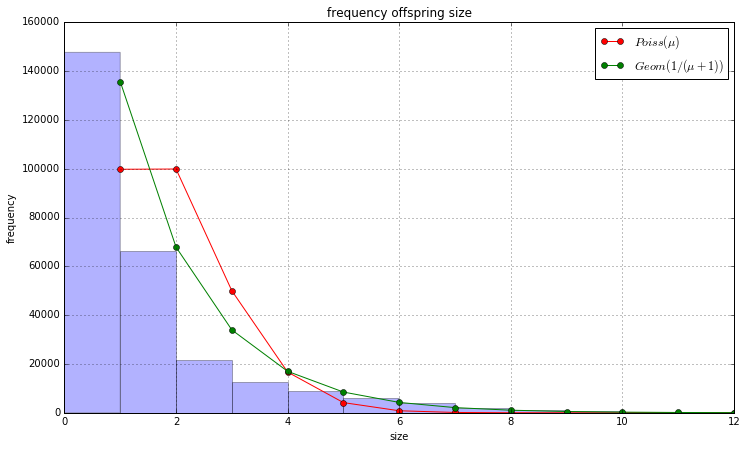

In [520]:
print(freq_all)
print(np.sum(freq_all))
n = np.sum(freq_all)
plt.figure(figsize=(12,7))
plt.title("frequency offspring size")
plt.hist(X_all, bins=np.arange(20) , facecolor='b', alpha=0.3)
plt.plot(np.arange(1,21) , [n*sps.poisson.pmf(x,mu=pois_lmb_all) for x in range(20)] ,
         '-o' ,color='r', label = r'$Poiss(\mu)$')
plt.plot(np.arange(1,21) , [n*sps.geom.pmf(x+1,1/(pois_lmb_all+1)) for x in range(20)] ,
         '-o' ,color='g',  label = r'$Geom(1/(\mu+1))$')
plt.legend()
plt.grid(True)
plt.xlim(0,12)
plt.xlabel("size")
plt.ylabel("frequency")
plt.show()

Критерий $\chi^2$ :

In [449]:
def get_chisquare_check(prob, f_obs, mu) :
    n = np.sum(f_obs)
    fexp = [n*prob(i,mu) for i in range(len(f_obs))]
    val , p = sps.chisquare(f_obs, f_exp=fexp)
    return val,p

In [473]:
poiss_f = lambda x,mu : sps.poisson.pmf(x,mu)
geom_f = lambda x,p : sps.geom.pmf(x+1,p)
print(get_chisquare_check(poiss_f,freq_all,pois_lmb_all+3.1))
print(get_chisquare_check(geom_f,freq_all,1/(pois_lmb_all + 1)))

(4838039.9170249132, 0.0)
(11316.003885842561, 0.0)
